# ML Pipeline de Operaciones en Flood para Predecir Destruction Level con RandomForestClassifier

## Versión 2 o Test B
Diferencia respecto a original: Este aplica filtro > 0 para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

## Objetivos

### Predecir Destruction Level (y numérica) a partir de X con features numéricas.

Agrupar múltiples operaciones en un mismo objeto:

* Borrar columnas, imputar valores faltantes
* Preprocessing: Umbrales y función estadística para determinar niveles de bajo a muy alto a imputar en columna categórica Flood Type.
* OneHotEncoder para pasar de columna categórica Flood Type a numérica Destruction Level.
* Pipeline:
    + Imputar most_frequent a nulos con SimpleImputer
    + Escalar características numéricas
    + RandomForestClassifier
* Modelado para predecir Destruction Level

## Importar librerías

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import RandomForestClassifier # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Destruction Level en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Convertir columnas categóricas (Disaster Subtype, Origin, Associated Disaster) a numéricas para predecir Destruction Level Dis o Mag Value
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

## Cargar datos

In [61]:
df = pd.read_csv('../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,...,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,...,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,...,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,...,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,...,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,...,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [62]:
df.shape

(16636, 26)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [64]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [65]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

### Filtro Flood

In [66]:
# Filtro principal para Flood
df_flood = df[df['Disaster Type'] == 'Flood']

### Limpieza

#### Borrar columnas

In [67]:
df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_14540\2601801454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)


In [68]:
df_flood.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,NaN,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,NaN,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0


### Valores faltantes

In [69]:
# # Rellenar valores faltantes y nulls con 0, después, borrar filas con valores faltantes
# df_flood = df_flood.copy()
# df_flood.fillna(0, inplace=True)

## Preprocessing

## Preprocessing 1: crear columna categórica Flood Type y codificar columna numérica Destruction Level con OneHotEncoder para predecir y

### Filtro para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

In [70]:
df_flood = df[(df['Dis Mag Value'] > 0) & 
                 (df['Total Deaths'] > 0) & 
                 (df['Total Affected'] > 0) & 
                 (df['Total Damages Adj'] > 0)]

In [71]:
df_flood['Dis Mag Value'].min()

1

In [72]:
df_flood.shape

(1727, 26)

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Nivel de Destrucción

In [73]:
min_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min()
max_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max()
std_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median()

min_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min()
max_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max()
std_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std()
mean_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean()
median_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median()

min_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median()

In [74]:
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median())

print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median())

print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median())

print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median())

1
2857000
173961.97483786722
47611.13607411696
210.0
1
242000
11460.354803714767
1235.348002316155
23.0
2
238973000
9656036.828331122
1480856.2733063116
36900.0
2
273218373
11529641.319038434
2140629.5645628255
146323.0


### Tipos de umbrales de peligrosidad de inundación

In [75]:
type1_threshold = min_dis_mag + std_dis_mag
type2_threshold = min_dis_mag + (2 * std_dis_mag)
type3_threshold = max_dis_mag - std_dis_mag

### Función para crear columna categórica de nivel de impacto: Flood Type

In [76]:
# def assign_flood_type(row):
#     dis_mag_value = row['Dis Mag Value']
#     total_deaths = row['Total Deaths']
#     total_affected = row['Total Affected']
#     total_damages = row['Total Damages Adj']
    
#     if dis_mag_value == 0:
#         return 'No Impact'
#     elif dis_mag_value < type1_threshold and total_deaths < 100 and total_affected < 10000 and total_damages < 1000000:
#         return 'Low' # 1
#     elif dis_mag_value < type2_threshold and total_deaths < 500 and total_affected < 100000 and total_damages < 10000000:
#         return 'Moderate' # 2
#     elif dis_mag_value < type3_threshold and total_deaths < 1000 and total_affected < 500000 and total_damages < 100000000:
#         return 'High' # 3
#     else:
#         return 'Very High' # 4

In [77]:
# Función previa que no considera valores nulos
def assign_flood_type(row):
    if row['Dis Mag Value'] < type1_threshold and row['Total Deaths'] < 100 and row['Total Affected'] < 10000 and row['Total Damages Adj'] < 1000000:
        return 'Low' # 1
    elif row['Dis Mag Value'] < type2_threshold and row['Total Deaths'] < 500 and row['Total Affected'] < 100000 and row['Total Damages Adj'] < 10000000:
        return 'Moderate' # 2
    elif row['Dis Mag Value'] < type3_threshold and row['Total Deaths'] < 1000 and row['Total Affected'] < 500000 and row['Total Damages Adj'] < 100000000:
        return 'High' # 3
    else:
        return 'Very High' # 4

In [78]:
df_flood['Flood Type'] = df_flood.apply(assign_flood_type, axis=1)
df_flood.head(20)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_14540\3488395721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Flood Type'] = df_flood.apply(assign_flood_type, axis=1)


,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type
64,1922-0011-CAN,1922,11,Climatological,Wildfire,Forest fire,Canada,CAN,Northern America,Americas,...,1922,9,30,1922,9,30,43,11000,139559,Moderate
135,1939-0001-CHL,1939,1,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1939,1,24,1939,1,24,30000,58500,19312844,Very High
151,1943-0010-CHL,1943,10,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1943,4,6,1943,4,6,12,35,1687452,Moderate
158,1944-0002-ARG,1944,2,Geophysical,Earthquake,Ground movement,Argentina,ARG,South America,Americas,...,1944,1,15,1944,1,15,10000,155000,1658743,Very High
184,1949-0010-ECU,1949,10,Geophysical,Earthquake,Ground movement,Ecuador,ECU,South America,Americas,...,1949,8,5,1949,8,5,6000,100000,245448,Very High
185,1949-0005-CHL,1949,5,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1949,4,19,1949,4,19,35,155,478623,Low
186,1949-0015-CHL,1949,15,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1949,12,17,1949,12,17,6,18,63816,Low
216,1953-0012-CHL,1953,12,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1953,5,6,1953,5,6,12,40,5456933,Moderate
218,1953-0001-GRC,1953,1,Geophysical,Earthquake,Ground movement,Greece,GRC,Southern Europe,Europe,...,1953,8,12,1953,8,12,476,141277,1091387,High
221,1953-0021-CHL,1953,21,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1953,12,6,1953,12,6,3,15,79780,Low


### Codificación categórica a numérica

#### Convertir Flood Type a Destruction Level numérica con OneHotEncoder

In [79]:
# Crear instancia de OneHotEncoder
encoder = OneHotEncoder()

# Ajustar y transformar la columna 'Flood Type'
flood_type_encoded = encoder.fit_transform(df_flood[['Flood Type']]).toarray()

# Obtener valores únicos en columna 'Flood Type'
unique_flood_types = df_flood['Flood Type'].unique()

# # Crear nuevos nombres de columna para las columnas codificadas
# encoded_feature_names = [f'Flood Type_{flood_type}' for flood_type in unique_flood_types]

# # Crear nuevo DataFrame para las columnas codificadas
# df_encoded = pd.DataFrame(flood_type_encoded, columns=encoded_feature_names)

# # Aplicar one-hot encoding a columna 'Flood Type'
# flood_type_encoded = pd.get_dummies(df_flood['Flood Type'], prefix='Flood Type')

# # Concatenar el DataFrame codificado con el original
# df_flood_encoded = pd.concat([df_flood, flood_type_encoded], axis=1)

# # DataFrame actualizado
# print(df_flood_encoded.head())

# Definir un diccionario de mapeo para las categorías en 'Flood Type' a valores numéricos
destruction_mapping = {'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

# Crear una nueva columna 'Destruction Level' mapeando las categorías 'Flood Type' a valores numéricos
df_flood['Destruction Level'] = df_flood['Flood Type'].map(destruction_mapping)

# Aplicar one-hot encoding a columna 'Flood Type'
destruction_encoded = pd.get_dummies(df_flood['Destruction Level'], prefix='Destruction')

# Concatenar el DataFrame codificado con el original
df_flood_encoded = pd.concat([df_flood, destruction_encoded], axis=1)

# DataFrame actualizado
print(df_flood_encoded.head())


            Dis No  Year  Seq Disaster Subgroup Disaster Type  \
64   1922-0011-CAN  1922   11    Climatological      Wildfire   
135  1939-0001-CHL  1939    1       Geophysical    Earthquake   
151  1943-0010-CHL  1943   10       Geophysical    Earthquake   
158  1944-0002-ARG  1944    2       Geophysical    Earthquake   
184  1949-0010-ECU  1949   10       Geophysical    Earthquake   

    Disaster Subtype    Country  ISO            Region Continent  ... End Day  \
64       Forest fire     Canada  CAN  Northern America  Americas  ...      30   
135  Ground movement      Chile  CHL     South America  Americas  ...      24   
151  Ground movement      Chile  CHL     South America  Americas  ...       6   
158  Ground movement  Argentina  ARG     South America  Americas  ...      15   
184  Ground movement    Ecuador  ECU     South America  Americas  ...       5   

    Total Deaths Total Affected  Total Damages Adj Flood Type  \
64            43          11000             139559   Mode

C:\Users\AleEng\AppData\Local\Temp\ipykernel_14540\2008063618.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Destruction Level'] = df_flood['Flood Type'].map(destruction_mapping)


#### Revisión df_flood_encoded

In [80]:
df_flood_encoded.shape

(1727, 32)

In [81]:
len(df_flood_encoded)

1727

In [82]:
df_flood_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1727 entries, 64 to 16539
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             1727 non-null   object
 1   Year               1727 non-null   int64 
 2   Seq                1727 non-null   int64 
 3   Disaster Subgroup  1727 non-null   object
 4   Disaster Type      1727 non-null   object
 5   Disaster Subtype   1624 non-null   object
 6   Country            1727 non-null   object
 7   ISO                1727 non-null   object
 8   Region             1727 non-null   object
 9   Continent          1727 non-null   object
 10  Location           1699 non-null   object
 11  Origin             607 non-null    object
 12  Associated Dis     671 non-null    object
 13  Dis Mag Value      1727 non-null   int64 
 14  Dis Mag Scale      1723 non-null   object
 15  Latitude           757 non-null    object
 16  Longitude          757 non-null    objec

In [83]:
df_flood.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [84]:
df_flood['Destruction Level']

64       2
135      4
151      2
158      4
184      4
        ..
16495    4
16524    1
16527    1
16537    1
16539    2
Name: Destruction Level, Length: 1727, dtype: int64

In [85]:
df_flood['Destruction Level'].isnull().sum()

0

#### Imputación de nulos en columna salida (y) Destruction Level con Simple Imputer

In [86]:
# Imputar nulos en la columna de salida (y) que es Destruction Level
df_flood['Destruction Level'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])
df_flood['Destruction Level']
# borrar en lugar de imputar
# df = df.dropna('Flood Type')

C:\Users\AleEng\AppData\Local\Temp\ipykernel_14540\2005245492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Destruction Level'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])


64       2
135      4
151      2
158      4
184      4
        ..
16495    4
16524    1
16527    1
16537    1
16539    2
Name: Destruction Level, Length: 1727, dtype: int64

In [87]:
df_flood['Flood Type'].isna().sum()
df_flood['Flood Type'].unique()
len(df_flood['Flood Type'])

1727

### EDA Visualizaciones de 'Destruction Level' o Nivel de Destrucción

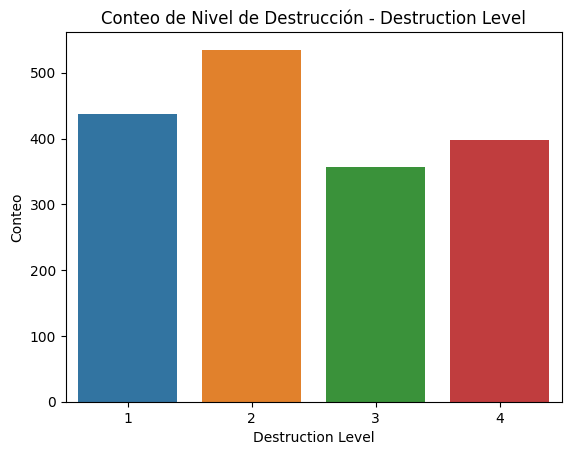

In [88]:
sns.countplot(data=df_flood, x='Destruction Level')
plt.title('Conteo de Nivel de Destrucción - Destruction Level')
plt.xlabel('Destruction Level')
plt.ylabel('Conteo')
plt.show()

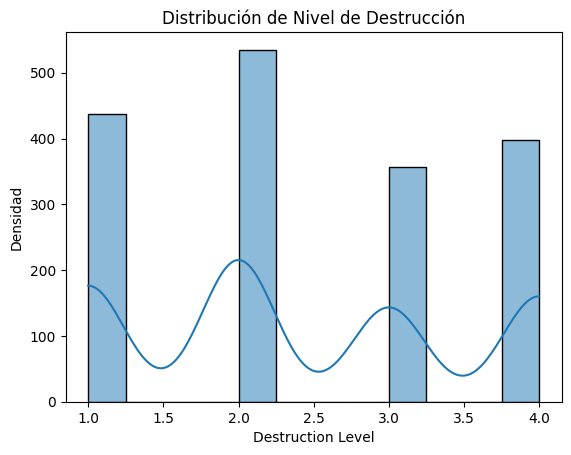

In [89]:
sns.histplot(data=df_flood, x='Destruction Level', kde=True)
plt.title(f'Distribución de Nivel de Destrucción')
plt.xlabel('Destruction Level')
plt.ylabel('Densidad')
plt.show()

Con el filtro > 0 cambia la densidad por nivel de destrucción, siendo 2 la más alta, seguida de 1 y 4.

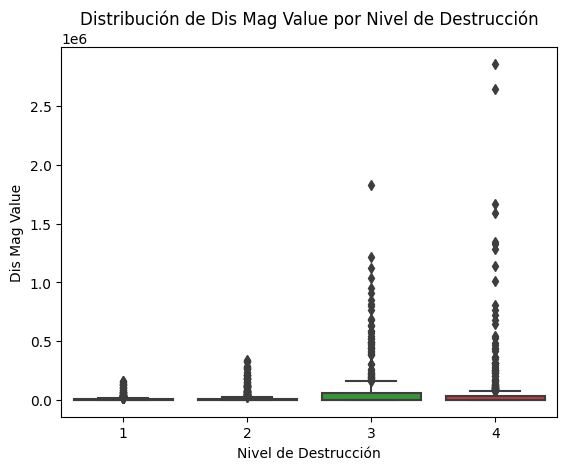

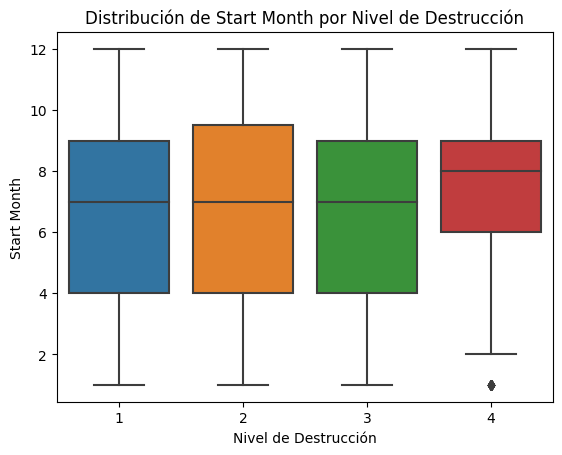

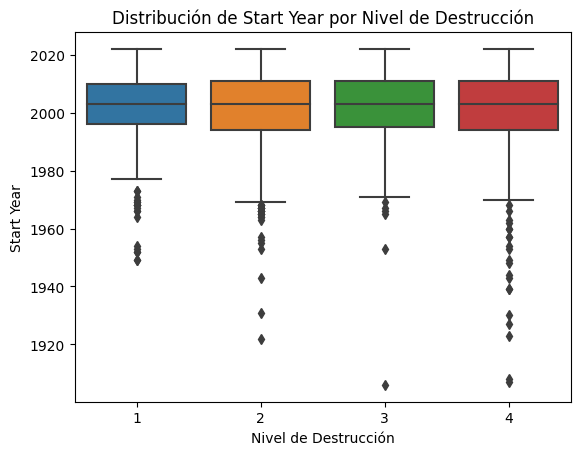

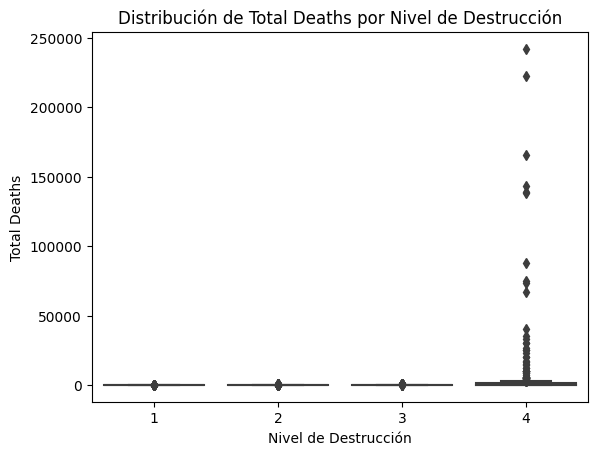

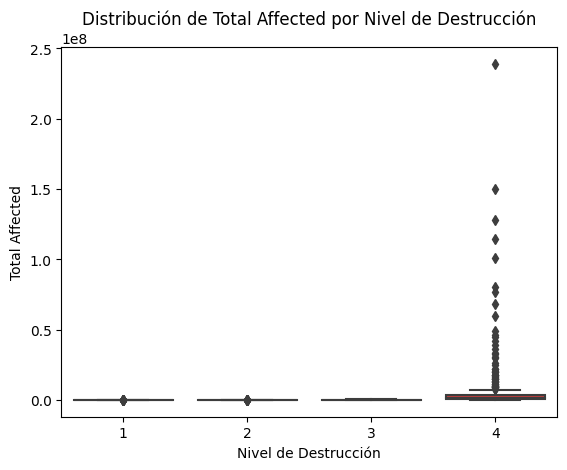

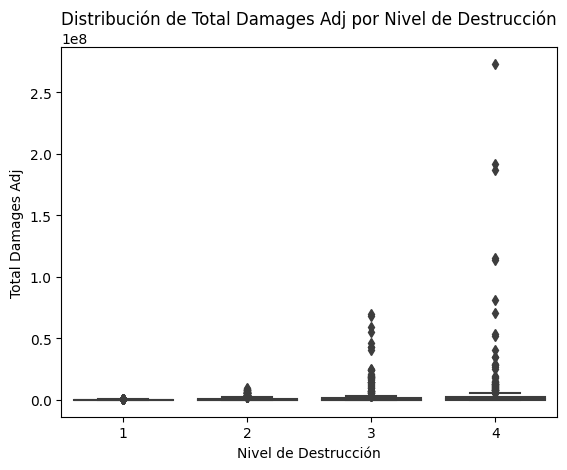

In [90]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected', 'Total Damages Adj']
for col in num_cols:
    sns.boxplot(data=df_flood, x='Destruction Level', y=col)
    plt.title(f'Distribución de {col} por Nivel de Destrucción')
    plt.xlabel('Nivel de Destrucción')
    plt.ylabel(col)
    plt.show()

In [91]:
# sns.pairplot(df_flood)
# Demasiado tiempo para procesar

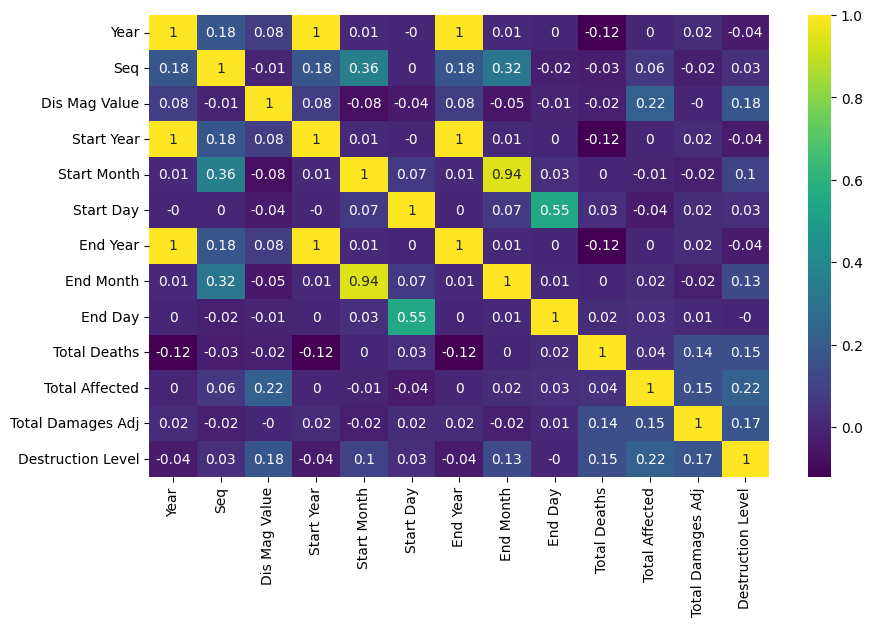

In [92]:
plt.figure(figsize=(10, 6))
df_corr = df_flood.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Destruction Level'>

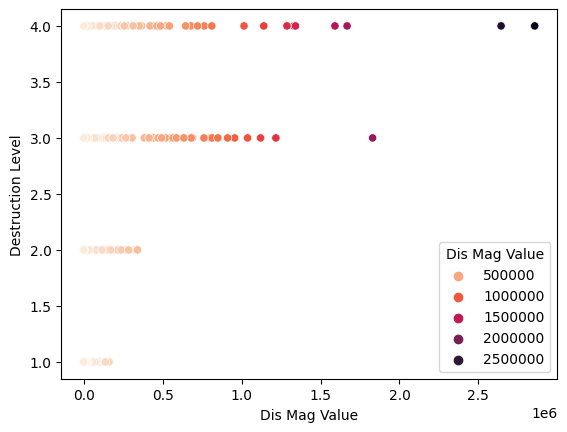

In [93]:
sns.scatterplot(data=df_flood, x='Dis Mag Value', y='Destruction Level', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Destruction Level'>

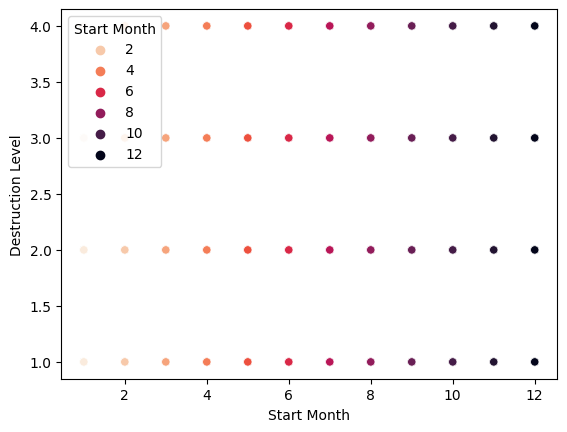

In [94]:
sns.scatterplot(data=df_flood, x='Start Month', y='Destruction Level', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Destruction Level'>

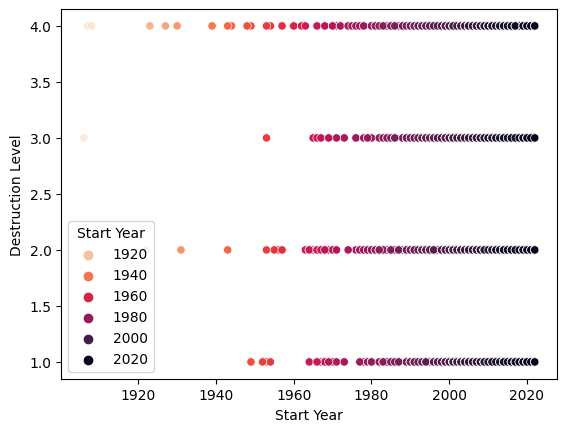

In [95]:
sns.scatterplot(data=df_flood, x='Start Year', y='Destruction Level', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Destruction Level'>

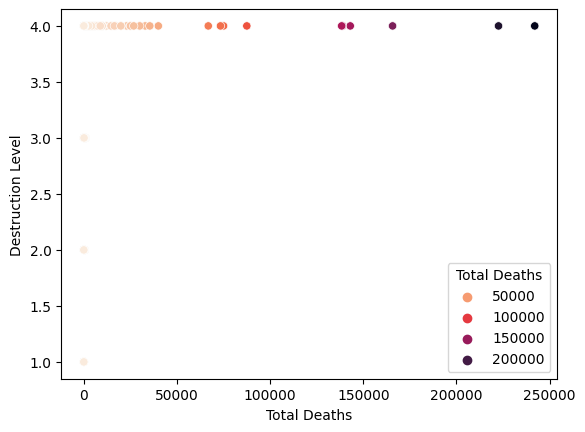

In [96]:
sns.scatterplot(data=df_flood, x='Total Deaths', y='Destruction Level', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Destruction Level'>

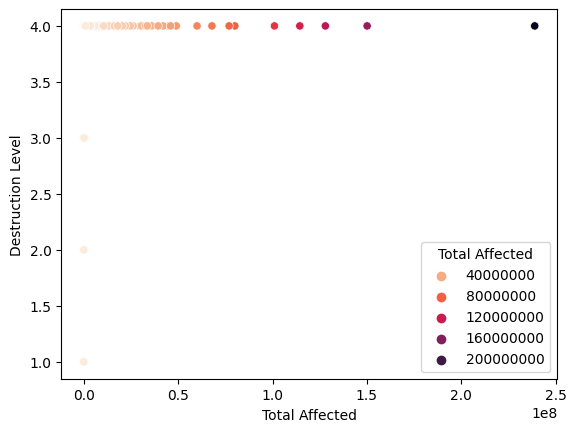

In [97]:
sns.scatterplot(data=df_flood, x='Total Affected', y='Destruction Level', hue='Total Affected', palette='rocket_r')

<Axes: xlabel='Total Damages Adj', ylabel='Destruction Level'>

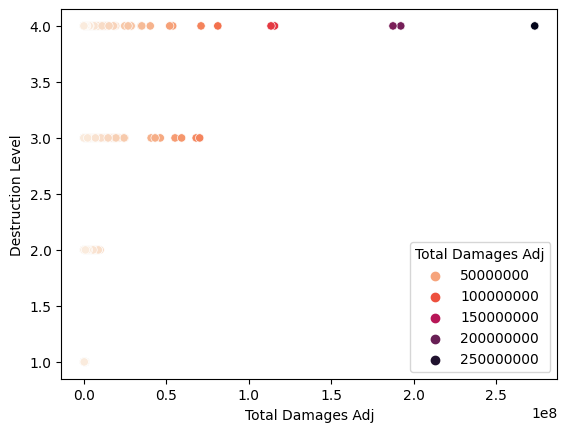

In [98]:
sns.scatterplot(data=df_flood, x='Total Damages Adj', y='Destruction Level', hue='Total Damages Adj', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Destruction Level'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Nivel de destrucción' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Nivel de destrucción'. Indica que podría haber alguna variación en el 'Nivel de destrucción' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Nivel de destrucción'. Sugiere que podría haber algunas tendencias o patrones en el 'Nivel de destrucción' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Nivel de Destrucción'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Nivel de destrucción'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'nivel de destrucción' más alto.
* La sexta visualización representa la relación entre 'Total Damages Adj' y 'Destruction Level'. Indica que un 'Ajuste total de daños' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.

## Preparar X y

In [99]:
# X = df_flood.drop(['Destruction Level', 'Destruction_1', 'Destruction_2', 'Destruction_3', 'Destruction_4'], axis=1)
# Dio problemas porque 'Destruction_1', 'Destruction_2', 'Destruction_3', 'Destruction_4' no existen en df_flood

X = df_flood.select_dtypes(exclude=['object'])  # Excluir columnas categóricas
X = X.drop('Destruction Level', axis=1)  # Quitar 'Destruction Level' de X
y = df_flood['Destruction Level']

## train_test_split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (1381, 12), (1381,)
test: (346, 12), (346,)


# Modelo

## Definir el Modelo

#### Pipeline columnas numéricas

In [101]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes usando most_frequent
    ('scaler', StandardScaler()),  # Escalar características numéricas
    ('classifier', RandomForestClassifier()) # Modelo elegido a partir de validación al ser el mejor del ranking
])

## Ejecución de pipeline

### Entrenar el modelo

In [102]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

#### Explicación de pipeline:
Incluye los siguientes pasos: SimpleImputer, StandardScaler y RandomForestClassifier.
* SimpleImputer para manejar los valores faltantes en los datos.
* StandardScaler para estandarizar las características numéricas, asegurando que tengan una media cero y una varianza unitaria.
* RandomForestClassifier es el modelo de clasificación elegido.

## Ejecución de pipeline

In [103]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Guardar pipeline

Se usa joblib para guardar modelos o pipelines.

Serializa un modelo o pipeline (objeto Python) a una secuencia de bytes que se almacenan en un archivo

* joblib.dump()
* joblib.load()

In [104]:
# pickle .pkl o .joblib
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLv2.pkl') # más genérico
joblib.dump(pipeline, 'pipelineRFC_Flood_DestructionLv2.joblib') # más eficiente con muchos datos

['pipelineRFC_Flood_DestructionLv2.joblib']

## Cargar pipeline

In [105]:
pipeline = joblib.load('pipelineRFC_Flood_DestructionLv2.joblib')
pipeline.predict(X_test)[:10]

array([2, 1, 1, 3, 2, 1, 2, 2, 2, 4], dtype=int64)

# Evaluar Modelo

### Predicción y_pred

In [106]:
y_pred = pipeline.predict(X_test)

In [107]:
y_pred.shape

(346,)

# Últimas comprobaciones dataframe

In [108]:
df_flood.head(100)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type,Destruction Level
64,1922-0011-CAN,1922,11,Climatological,Wildfire,Forest fire,Canada,CAN,Northern America,Americas,...,9,30,1922,9,30,43,11000,139559,Moderate,2
135,1939-0001-CHL,1939,1,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,1,24,1939,1,24,30000,58500,19312844,Very High,4
151,1943-0010-CHL,1943,10,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,4,6,1943,4,6,12,35,1687452,Moderate,2
158,1944-0002-ARG,1944,2,Geophysical,Earthquake,Ground movement,Argentina,ARG,South America,Americas,...,1,15,1944,1,15,10000,155000,1658743,Very High,4
184,1949-0010-ECU,1949,10,Geophysical,Earthquake,Ground movement,Ecuador,ECU,South America,Americas,...,8,5,1949,8,5,6000,100000,245448,Very High,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,1977-0078-TON,1977,78,Geophysical,Earthquake,Ground movement,Tonga,TON,Polynesia,Oceania,...,6,23,1977,6,23,1,5505,5794,Low,1
1814,1978-0115-IRN,1978,115,Geophysical,Earthquake,Ground movement,Iran (Islamic Republic of),IRN,Southern Asia,Asia,...,9,16,1978,9,16,25000,40000,224314,Very High,4
1818,1978-0080-JPN,1978,80,Geophysical,Earthquake,Ground movement,Japan,JPN,Eastern Asia,Asia,...,6,12,1978,6,12,28,2500,3880630,Moderate,2
1830,1978-0040-MOZ,1978,40,Hydrological,Flood,NaN,Mozambique,MOZ,Eastern Africa,Africa,...,3,0,1978,3,0,40,200000,282635,High,3


In [109]:
df_flood.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [110]:
df_flood.isnull().sum()

Dis No                  0
Year                    0
Seq                     0
Disaster Subgroup       0
Disaster Type           0
Disaster Subtype      103
Country                 0
ISO                     0
Region                  0
Continent               0
Location               28
Origin               1120
Associated Dis       1056
Dis Mag Value           0
Dis Mag Scale           4
Latitude              970
Longitude             970
Start Year              0
Start Month             0
Start Day               0
End Year                0
End Month               0
End Day                 0
Total Deaths            0
Total Affected          0
Total Damages Adj       0
Flood Type              0
Destruction Level       0
dtype: int64

In [111]:
df_flood['Destruction Level'].min()

1

### Pivot Tables

In [112]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='min')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,4,2,2,1
2,1,2,90,1
3,5,280,71,1
4,6,750,480,2


In [113]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='max')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,162400,9480,979883,98
2,340197,95008,9915168,498
3,1829701,498924,70201819,922
4,2857000,238973000,273218373,242000


In [114]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='sum')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,4453762,951047,67236606,5479
2,13056798,15235233,456982586,25929
3,31887631,73563365,1101409095,36568
4,32826241,2467689139,2071238971,2065470


In [115]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='mean')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,10168.406393,2.171340e+03,1.535082e+05,12.509132
2,24405.229907,2.847707e+04,8.541731e+05,48.465421
3,89571.997191,2.066387e+05,3.093846e+06,102.719101
4,82477.992462,6.200224e+06,5.204118e+06,5189.623116


In [116]:
df_floodresult_pivot_table = pd.pivot_table(df_flood, index='Destruction Level', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='median')
df_floodresult_pivot_table

,Dis Mag Value,Total Affected,Total Damages Adj,Total Deaths
Destruction Level,,,,
1,160.5,1207.5,44981.0,5.0
2,180.0,20030.0,121936.0,15.0
3,310.0,200000.0,243915.0,38.5
4,215.5,1489994.5,525727.5,189.0


# Reporte de Clasificación

La precisión, la recuperación y la puntuación F1 son métricas de evaluación de uso común en modelos de aprendizaje automático, particularmente en tareas de clasificación. Estas métricas brindan información sobre el rendimiento del modelo y su capacidad para clasificar correctamente las instancias.

* Precision: la precisión mide la proporción de instancias positivas pronosticadas correctamente (positivos verdaderos) de todas las instancias pronosticadas como positivas (positivos verdaderos + positivos falsos). En otras palabras, la precisión indica qué tan preciso o exacto es el modelo cuando predice una clase positiva. Una puntuación de alta precisión sugiere que el modelo tiene una baja tasa de falsos positivos.

* Recall: la recuperación, también conocida como sensibilidad o tasa de verdaderos positivos, mide la proporción de instancias positivas pronosticadas correctamente (verdaderos positivos) de todas las instancias positivas reales (verdaderos positivos + falsos negativos). Representa la capacidad del modelo para identificar o capturar instancias positivas. Una puntuación de recuerdo alta sugiere que el modelo tiene una tasa baja de falsos negativos.

* f1-score: La puntuación F1 es la media armónica de precisión y recuperación. Proporciona una medida equilibrada que considera simultáneamente la precisión y la recuperación. La puntuación F1 combina precisión y recuperación en una sola métrica y proporciona una evaluación más completa del rendimiento del modelo. Es especialmente útil cuando se trata de conjuntos de datos desequilibrados, donde la distribución de clases es desigual.

Al interpretar estas métricas, es fundamental tener en cuenta los objetivos y requisitos específicos de la tarea de clasificación. Es deseable una puntuación de alta precisión cuando es crucial minimizar los falsos positivos. Por otro lado, una puntuación alta de recuerdo es deseable cuando la captura de tantos positivos verdaderos como sea posible es una prioridad. La puntuación F1 proporciona una vista equilibrada, teniendo en cuenta tanto la precisión como la recuperación.

En resumen, la precisión, la recuperación y la puntuación F1 son métricas valiosas para evaluar el rendimiento de un modelo de clasificación, que brindan información sobre su precisión, capacidad para capturar instancias positivas y rendimiento general equilibrado.

In [117]:
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        90
           2       0.97      0.98      0.98       115
           3       1.00      0.97      0.99        69
           4       1.00      0.99      0.99        72

    accuracy                           0.99       346
   macro avg       0.99      0.98      0.99       346
weighted avg       0.99      0.99      0.99       346



Resultados de 1er reporte de clasificación

Reporte de Clasificación 1:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        90
           2       0.97      0.98      0.97       115
           3       1.00      0.94      0.97        69
           4       1.00      1.00      1.00        72

    accuracy                           0.98       346
   macro avg       0.99      0.98      0.98       346
weighted avg       0.98      0.98      0.98       346

Según el informe de clasificación, el modelo parece funcionar bien, logrando una alta precisión, recuperación y puntuación F1 para cada clase. La alta precisión sugiere que el modelo es capaz de predecir el 'Nivel de destrucción' con un alto grado de corrección. Sin embargo, es importante tener en cuenta que sería necesario un mayor análisis y consideración de otras métricas de evaluación, como la validación cruzada o la validación de datos no vistos, para obtener una evaluación integral del rendimiento del modelo.

#### Interpretación de primer Reporte de Clasificación con RandomForestClassifier:

### Evaluación con mae, rmse y r2

In [118]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R^2):", r2)

Mean Absolute Error (MAE): 0.017341040462427744
Root Mean Squared Error (RMSE): 0.1520571842539411
Coefficient of Determination (R^2): 0.9801623988590513


#### Resultados de mae, rmse y r2

Mean Absolute Error (MAE): 0.017341040462427744
+ El error absoluto medio representa la diferencia absoluta media entre los valores predichos y los valores reales. En este caso, la diferencia absoluta media es de aproximadamente 0.0173. Los valores más bajos de MAE indican que las predicciones del modelo están más cerca de los valores reales y, por lo tanto, el modelo tiene una buena precisión al hacer predicciones.


Error cuadrático medio (RMSE): 0.13168538439184413
* El error cuadrático medio es otra métrica que mide la diferencia promedio entre los valores predichos y los valores reales, pero penaliza los errores grandes más que MAE. En este caso, el RMSE es de aproximadamente 0.1317, siendo superior al MAE, aunque los valores más bajos de RMSE indican que las predicciones del modelo están más cerca de los valores reales, lo que sugiere una buena precisión.


Coeficiente de Determinación (R^2): 0.9851217991442884

* El valor R-cuadrado, también conocido como coeficiente de determinación, mide qué tan bien el modelo explica la varianza en la variable objetivo. Va de 0 a 1, donde 1 indica un ajuste perfecto a los datos. En este caso, el valor de R-cuadrado es de aproximadamente 0,9851, que está muy cerca de 1. Esto indica que el modelo explica alrededor del 98,51 % de la varianza en la variable objetivo, y se considera un ajuste fuerte del modelo.

El informe de clasificación proporciona métricas de evaluación para el modelo RandomForestClassifier.
La precisión, el recuerdo (recall) y la puntuación F1 (f1-score) se informan para cada clase (1, 2, 3, 4), junto con el soporte (número de muestras) para cada clase.
También se informa la precisión del modelo: 1, lo que indica la corrección general de las predicciones.
Las métricas de macro avg o macropromedio y weighted avg o promedio ponderado proporcionan medidas de rendimiento agregadas en todas las clases.

# Conclusiones de la versión 2 o Test B

De acuerdo al reporte de clasificación, el modelo RandomForestClassifier v2 funciona muy bien al hacer predicciones, como lo indican los valores bajos de MAE y RMSE y el valor alto de R-cuadrado. Parece estar capturando los patrones subyacentes en los datos de manera efectiva y proporcionando predicciones precisas para el 'Nivel de Destrucción' en función de las características de entrada.

Sin embargo, cabe recordar que en este test B o versión 2 se realizó un filtro previo para excluir los valores de 0 en columnas de Dis Mag Value, Total Deaths, Total Affected y Total Damages Adj, provocando que los resultados de densidad de los Niveles de Destrucción varíen mucho respecto a los del test A donde se conservaron valores íntegros, es decir, también se consideraron las filas con 0 que mostraban alguna relación o valor perteneciente a Filtro Flood.

El test A o versión 1 se desempeña mejor que este, test B o versión 2 en los resultados, aunque la duda de si deben conservarse los valores totales persiste.

# Recomendaciones

Aunque en el desempeño parezca que el Test A funciona mejor, es más confiable excluir los valores 0 previamente, aunque se reduzca la muestra considerablemente, como en el caso de este Test B.

Si el 'Valor Dis Mag' de 0 indica datos faltantes o desconocidos, podría ser mejor excluir esas filas de la predicción del modelo. Al hacerlo, se asegura de que el modelo haga predicciones solo en función de datos significativos y confiables. Incluir filas con valores faltantes o desconocidos en la predicción puede generar ruido y afectar potencialmente la precisión de las predicciones del modelo.

Por otro lado, el modelo también podría estar aprendendiendo de datos disponibles de otras columnas donde sí hay valores relacionados al evento Flood (recordemos que se realizó un filtro previo específico) aunque en 'Dis Mag Value' aparezca 0, y hacer predicciones en consecuencia.

En resumen, la decisión de filtrar filas de manera segmentada con 'Dis Mag Value' u otras columnas pretende abordar el reto específico de nuestro dataset que es la inconsistencia de los mismos, debido a que no son fenómenos que ocurran de una forma constante ni ordenada, sino más bien aleatoria y dependiente de otros factores con los que no contamos, incluyendo muchos que no se recolectaron.